In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import random

In [2]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_pred_unq =  np.unique(y_pred)
    for i in y_pred_unq:
        if((i != -1) & (i!= 1) & (i!= 0) ):
            raise ValueError('The predictions can contain only -1, 1, or 0!')
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

In [3]:
X_train_fname = '../data/training_templates.csv'
y_train_fname = '../data/training_labels.txt'
X_test_fname  = '../data/testing_templates.csv'
X_train = pd.read_csv(X_train_fname, sep=',', header=None).values
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None).values
y_train = np.loadtxt(y_train_fname, dtype=np.int)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

random.seed(42)

t0 = time()

"""
# Construct new training set according to the portion of the two classes in test set.
X_train1 = X_train[y_train == 1]
X_train2 = X_train[y_train == -1]
indices = np.random.permutation((y_train == -1).sum())
indices = indices[:(y_train == -1).sum()/3]

X_train = np.r_[X_train1, X_train2[indices]]
y_train = np.r_[np.ones((y_train == 1).sum()), -np.ones((y_train == -1).sum()/3)].astype(np.int)
print X_train.shape, y_train.shape
print np.mean(y_train), np.unique(y_train)
"""

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#clf = GridSearchCV(BaggingClassifier(max_samples=0.7, max_features=0.7, bootstrap=True, bootstrap_features=True), params, scoring='roc_auc', cv=2, n_jobs=-1)
nn = MLPClassifier(hidden_layer_sizes=(256, 256, 256), alpha=1e-5, tol=1e-5)
clf = BaggingClassifier(base_estimator=nn, n_estimators=100, max_samples=0.5, max_features=0.7, bootstrap=True, bootstrap_features=True, n_jobs=-1)
clf.fit(X_train, y_train)

#print("Best parameters set found on training set:")
#print(clf.best_params_)
#print '\n'

print("Detailed classification report:")
print("The model is trained on the full training set with cross validation.")
print("The scores are computed on the full training set.")
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred))

print "Done in %0.3fs." % (time()-t0)

Detailed classification report:
The model is trained on the full training set with cross validation.
The scores are computed on the full training set.
             precision    recall  f1-score   support

         -1       1.00      1.00      1.00     52800
          1       1.00      1.00      1.00     52800

avg / total       1.00      1.00      1.00    105600

Done in 3428.887s.


In [5]:
y_pred_train = clf.predict(X_train)
y_pred_proba_train = clf.predict_proba(X_train)

score = compute_pred_score(y_train, y_pred_train)
print('Score sur le train : %s' % score)

for i in range(len(y_pred_train)):
    if max(y_pred_proba_train[i, :]) < 0.90:
        y_pred_train[i] = 0
score = compute_pred_score(y_train, y_pred_train)
print('Score sur le train : %s' % score)

Score sur le train : 0.0354166666667
Score sur le train : 0.0962215909091


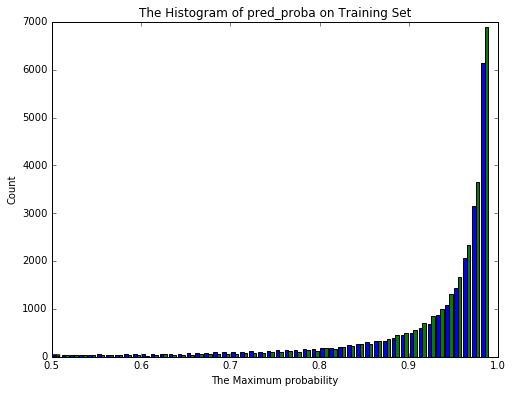

In [6]:
bins = np.arange(0.5, 1.0, 0.01)
plt.figure(1, figsize=(8,6))
plt.hist(y_pred_proba_train, bins=bins)
plt.title('The Histogram of pred_proba on Training Set')
plt.xlim(0.5, 1)
plt.xlabel('The Maximum probability')
plt.ylabel('Count')
plt.show()

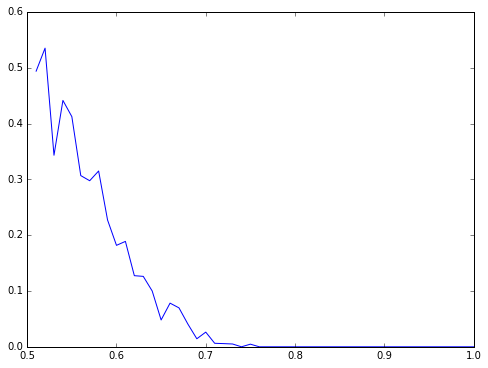

In [7]:
def error_rate(y_true, y_pred, y_pred_proba):
    y_pred_proba_max = np.amax(y_pred_proba, axis=1)
    rate = []
    bins = np.linspace(0.51, 1.00, 50)
    for b in bins:
        idx = (y_pred_proba_max < b) & (y_pred_proba_max >= b-0.01)
        y_t = y_true[idx]
        y_p = y_pred[idx]
        error = np.sum(y_t*y_p == -1)
        rate.append(float(error) / len(y_p))
    return rate

y_pred_train = clf.predict(X_train)
y_pred_proba_train = clf.predict_proba(X_train)

error_rate = error_rate(y_train, y_pred_train, y_pred_proba_train)
proba = np.linspace(0.51, 1.00, 50)
plt.figure(2, figsize=(8,6))
plt.xlim(0.5, 1)
plt.ylim(0, 0.6)
plt.plot(proba, error_rate)
plt.show()

In [22]:
y_pred = clf.predict(X_test)
print (y_pred==1).sum(), (y_pred==-1).sum()
np.savetxt('y_pred_bagging2.txt', y_pred, fmt='%d')
y_pred_proba = clf.predict_proba(X_test)

6599 1897


In [24]:
y_output = y_pred[:]
for i in range(len(y_pred)):
    if max(y_pred_proba[i, :]) < 0.70:
        y_output[i] = 0
np.savetxt('y_pred_bagging2_0.70.txt', y_output, fmt='%d')

for i in range(len(y_pred)):
    if max(y_pred_proba[i, :]) < 0.705:
        y_output[i] = 0
np.savetxt('y_pred_bagging2_0.705.txt', y_output, fmt='%d')